# Introduction à l'apprentissage par renforcement
# TP 1 - le bandit-manchot multi-bras

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

# Définition des vaccins

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class ArmBernoulli:
    def __init__(self, p: float, random_state: int = 0):
        """
        Bernoulli arm
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
        """
        self.mean = p
        self.local_random = np.random.RandomState(random_state)
        
    def sample(self, printable = False):
        random = self.local_random.rand()
        
        if printable:
            print (f"random: {random}, mean: {self.mean}")
        return random < self.mean

    
K = 5
T = 100
np.random.seed(1)
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

In [6]:
means

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01])

In [8]:
list(map(lambda arm: arm.mean, MAB))

[0.417022004702574,
 0.7203244934421581,
 0.00011437481734488664,
 0.30233257263183977,
 0.14675589081711304]

In [12]:
MAB[0].sample(printable=True)

random: 0.5488135039273248, mean: 0.417022004702574


False

**Vaccins :** ils sont notés $A_k\leq K$, leur probabilité d'immunisation est $p_k = \mu_k$.

**Récompense :** 1 si le patient $t$ est immunisé et 0 sinon.

**Action optimale :** choisir le vaccin $a$ avec la meilleure probabilité $a^* = \arg\max_{a\leq K} \mu_{a}$.

**Regret :** $R_T =T\mu_a^* - \mathbb{E} \left[ \sum_{t=1}^T r_t \right]$
En notant $N_a(t)$, le nombre de fois que le vaccin $a$ a été choisi jusqu'à $t$ et $\Delta_a = \mu_a^* - \mu_a$, le regret s'exprime :

$$R_T = \sum_{a=1}^K \Delta_a \mathbb{E} \left[ N_{a_T} \right]$$


**Expliquez ce que signifie le regret concrètement. Pourquoi minimiser le regret donne une bonne solution au problème du bandit-manchot**

# Solution naive

 La solution naive consiste en 2 étapes distinctes :

1. Entraînement : on teste les K vaccins sur N patients et on note leur efficacité séparemment
2. Exploitation : le vaccin qui apparaît comme le meilleur est choisi pour les T-N patients restants.

**Implémentez cet algorithme avec T=100, N=20, K=5. Quel bras a été choisi lors de la seconde phase ?**

##### Entrainement

In [20]:
N = 20
groupe_number = K # here 5 
groupe_size = int(N / groupe_number) # here 4
rewards = np.zeros((groupe_number, groupe_size)) 

for groupe in range(groupe_number):
    rewards[groupe] = [MAB[groupe].sample() for i in range(groupe_size)]

rewards
    



array([[0., 1., 0., 0.],
       [1., 1., 1., 0.],
       [0., 0., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]])

In [24]:
list_vaccin = rewards.flatten()
list_vaccin

array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0.])

In [22]:
best_groupe = np.argmax(rewards.mean(axis=1))
best_groupe

1

**Obtenez-vous toujours le résultat ? Testez l'algorithme avec une valeur de N plus faible. Qu'en concluez-vous ?**

**Tracez l'évolution du regret $r_t$ de votre algorithme en fonction du résultat obtenu avec le patient $t<T$ sur plusieurs expériences. Représentez l'évolution moyenne de ce regret sur plusieurs expériences.**

In [27]:
def Regret_i(T, mu, list_vaccine):
    E = np.mean(list_vaccine) 
    return T * mu - E

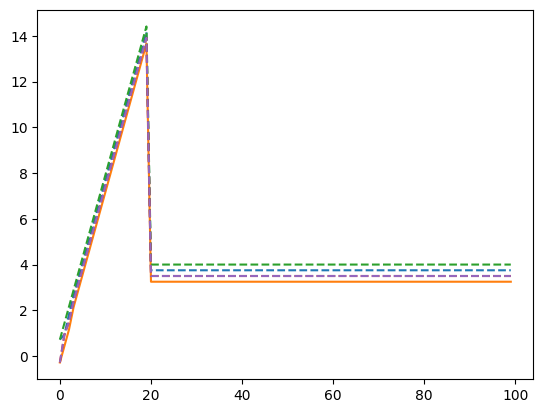

In [44]:
def compute_regret(l):
    list_vaccin = l.copy()
    r = []
    for i in range(N):
        r.append(Regret_i(i+1, MAB[1].mean, list_vaccin[:i+1]))
    for i in range(T-N):
        np.concatenate((list_vaccin, [MAB[1].sample()]))
        r.append(Regret_i(list_vaccin.shape[0], np.argmax(means), list_vaccin[:N+i+1]))
    return r

regrets = []
for i in range(K):
    regrets.append(compute_regret(rewards[i]))
    if i == best_groupe:
        plt.plot(regrets[i], label=f"best groupe {i}")
    else:
        plt.plot(regrets[i],  '--', label=f"groupe {i}",)


## Upper Confidence Bounds (P. Auer, 2002)

L'action $a_t$ l'instant $t$ est donnée par : 

$$a_t = max_a \left[ X_t(a) + B_t(a) \right]$$

où $X_t(a)$ est la moyenne empirique de la récompense obtenue avec le vaccin $a$ et $B_t(a)$ est un biais :

$$B_t(a) = \sqrt{ \frac{2\log t}{T_a}}$$ où $T_a$ est le nombre de fois que le vaccin $a$ a été choisi.

**Pourquoi cet algorithme n'a pas besoin d'une phase d'entraînement ? Quel terme favorise l'exploration et quel terme favorise l'exploitation ?**

**Implémentez l'algorithme et tracez l'évolution du regret à partir de cet algorithme.**

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps**

Ici, c'est à vous de réfléchir à la meilleure représentation de ces valeurs.

# Echantillonnage de Thomson

L'algorithme de Thompson calcule à chaque instant $t$ le paramètre des lois Beta pour tous les vaccins. Il échantillonne alors une probabilité de choisir chaque vaccin et choisit le vaccin avec la plus grande probabilité.

**Comment fonctionnent les lois Beta ? Comment les mettre à jour selon les résultats des vaccins ?**

**Comment se passent l'exploration et l'exploitation ?**

**Implémentez l'algorithme et tracez l'évolution du regret.**

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des probabilités au cours du temps**

Indice : pour représenter des probabilités, on pourra utiliser des diagrammes en violons.